# Code Division Multiplexing: HTC Tutorial using Jupyter notebooks

## Student project in High Throughput Computing

Author: Richard T. Jones, University of Connecticut, richard.t.jones(at)uconn.edu
<br>Created: March 19, 2022


Define a class for CDM encoding and decoding.

In [1]:
import numpy as np

class CDMcode:
    def __init__(self, log2length):
        """
        Constructs a new CDMcode object of length 2**log2length.
        Initialize the first code to a random bit string, and the
        subsequent log2length codes to the complete set of codes
        that are orthogonal to the first.
        """
        self.codelen = 1 << log2length
        arr = np.random.randint(2, size=self.codelen)
        code0 = np.array(arr, dtype=int)
        count = np.arange(self.codelen, dtype=int)
        self.code = [code0]
        self.coda = [2 * code0 - 1]
        self.codi = [-2 * code0 + 1]
        self.coda8 = [np.array(self.coda[0], dtype=np.byte)]
        self.codi8 = [np.array(self.codi[0], dtype=np.byte)]
        for n in range(log2length):
            coden = np.bitwise_xor(code0, (count >> n) & 1)
            self.code.append(coden)
            self.coda.append(2 * coden - 1)
            self.codi.append(-2 * coden + 1)
            self.coda8.append(np.array(self.coda[-1], dtype=np.byte))
            self.codi8.append(np.array(self.codi[-1], dtype=np.byte))
        self.codasum = [np.sum(coda) for coda in self.coda]
    
    def encode(self, message, chan):
        """
        Takes in a message bytestring and expands it into a signal
        array encoded using the code for channel chan, returning it
        as a numpy array of byte containing the bit values of the
        encoded message, length = len(message) * codelen * 8. The
        bit order in the encoded signal is big-endian.
        """
        bitstream = []
        for mbyte in message:
            for mbit in reversed(range(8)):
                if (mbyte >> mbit) % 2 == 0:
                    bitstream.append(self.codi8[chan])
                else:
                    bitstream.append(self.coda8[chan])
        return np.concatenate(bitstream)

    def decode(self, signal, chan, amp=1):
        """
        Takes in a signal array of bytes and decode any messages found
        in code channel chan. Null bits in the signal are treated as
        message termination. Valid message bits are expected to occur
        in sequences of 8 bits, otherwise a warning message is printed.
        The amplitude of the encoded signal is assumed to be amp.
        """
        dotmean = np.sum(signal) * self.codasum[chan] / len(signal)
        pthresh = dotmean + self.codelen * amp / 2
        nthresh = dotmean - self.codelen * amp / 2
        message = bytearray()
        pos = 0
        while pos + 8 * self.codelen <= len(signal):
            mbyte = 0
            for mbit in reversed(range(8)):
                sdotc = self.dot(signal[pos:], chan)
                if sdotc > pthresh:
                    mbyte += (1 << mbit)
                elif sdotc > nthresh:
                    if mbit != 7:
                        print("CDMcode.decode warning:",
                              "incomplete character found at position",
                              pos / self.codelen)
                    return bytes(message)
                pos += self.codelen
            message.append(mbyte)
        return bytes(message)
    
    def dot(self, signal, chan):
        """
        Take the inner product between the array signal[:codelen]
        and the code for channel chan. The signal array is assumed to
        be at least of length codelen.
        """
        return np.dot(self.coda[chan], signal[:self.codelen])

## Othogonality check

Check orthogonality of the codes in one or two special cases, N < 10. This "inner product" is defined as the sum over +1 for each bit position with the same value in the two vectors, and -1 for each bit position with the opposite value. You should verify that the inner product of any code with itself equals the number of bits, whereas the inner product is zero when taken with any of the other codes in the set.

In [2]:
N = 5
cdm = CDMcode(N)
for n in range(N+1):
    print("cdm[{0}]".format(n), ": ", end='')
    print(cdm.code[n])
    for m in range(n+1):
        print("   cdm[{0}] . cdm[{1}] = {2}".format(n, m, cdm.dot(cdm.encode(b'\x80', n), m)))


cdm[0] : [1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0]
   cdm[0] . cdm[0] = 32
cdm[1] : [1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1]
   cdm[1] . cdm[0] = 0
   cdm[1] . cdm[1] = 32
cdm[2] : [1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 1]
   cdm[2] . cdm[0] = 0
   cdm[2] . cdm[1] = 0
   cdm[2] . cdm[2] = 32
cdm[3] : [1 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1]
   cdm[3] . cdm[0] = 0
   cdm[3] . cdm[1] = 0
   cdm[3] . cdm[2] = 0
   cdm[3] . cdm[3] = 32
cdm[4] : [1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1]
   cdm[4] . cdm[0] = 0
   cdm[4] . cdm[1] = 0
   cdm[4] . cdm[2] = 0
   cdm[4] . cdm[3] = 0
   cdm[4] . cdm[4] = 32
cdm[5] : [1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1]
   cdm[5] . cdm[0] = 0
   cdm[5] . cdm[1] = 0
   cdm[5] . cdm[2] = 0
   cdm[5] . cdm[3] = 0
   cdm[5] . cdm[4] = 0
   cdm[5] . cdm[5] = 32


## Encode a message
Create a noisy baseline signal and encode a single message into it. Plot the signal, its amplitude distribution and its autocorrelation.

In [3]:
N = 16
chan = 3
cdm = CDMcode(N)
message = b"Around and around the rugged rocks the ragged rascal ran."
signal = np.array([], dtype=np.byte)
charlen = 8 * cdm.codelen
for a in message:
    arr = np.array(np.random.normal(64, 12.5, charlen), dtype=np.byte)
    signal = np.concatenate((signal, arr))
signal += cdm.encode(np.frombuffer(message, dtype=np.byte), chan)

message2 = b"But not without his umbrella!"
message2 = message2.ljust(len(message), b'\x00')
signal += cdm.encode(np.frombuffer(message2, dtype=np.byte), chan + 10)

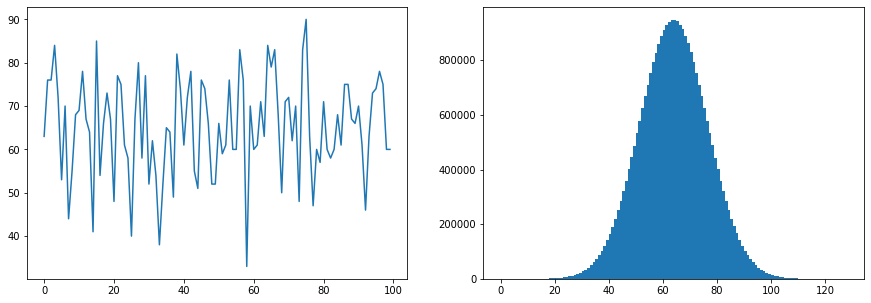

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
p1 = axes[0].plot(signal[:100])
p2 = axes[1].hist(signal, 128, (0, 128))

## Decode the signal, look for messages
Search the encoded signal for messages on any channel.

In [5]:
print("signal has length", round(len(signal) / 1e6), "MBytes")
for chan in range(N + 1):
    msg = cdm.decode(signal, chan)
    if len(msg) > 0:
        print('message found on channel {0}: "{1}"'.format(chan, msg.decode()))

signal has length 30 MBytes
message found on channel 3: "Around and around the rugged rocks the ragged rascal ran."
message found on channel 13: "But not without his umbrella!                            "


## Encode a signal too long to fit in memory
Send a short message again, but this time add null fill characters at the beginning and ending to make the total signal >250 GB long. Write the output to a text file, with one signal sample per line.

In [6]:
N = 16
dclevel = 64
bglevel = 12.5
cdm = CDMcode(N)
signal_out = open("cdm_signal_0.csv", "w")

def encode_one_char(cdm, char_column, dc=dclevel, bg=bglevel):
    """
    Look in array char_column indexed by channel for any characters
    to be CDM-encoded into the output signal, and append the signal
    to the output file.
    """
    charlen = cdm.codelen * 8
    signal = np.array(np.random.normal(dc, bg, charlen), dtype=np.byte)
    for chan in range(N+1):
        if chan < len(char_column) and len(char_column[chan]) > 0:
            signal += cdm.encode(char_column[chan][:1], chan)
    return signal

def append_to_signal_out(sigbytes):
    for sigbyte in sigbytes:
        signal_out.write("{0}\n".format(sigbyte))
    print("append_to_signal_out wrote {0} bytes".format(len(sigbytes)))

secret = [''] * (N+1)
secret[6] = b"Therefore, since brevity is the soul of wit,\n" +\
            b"And tediousness the limbs and outward flourishes,\n" +\
            b"I will be brief: your noble son is mad:\n"
secret[11] = b"Foul whisperings are abroad: unnatural deeds\n" +\
            b"Do breed unnatural troubles: infected minds\n" +\
            b"To their deaf pillows will discharge their secrets:\n"

prefixlen = 3689100 #1
prefixlen = 2240915 #2
prefixlen = 7760023 #3
prefixlen = 1463980 #4
prefixlen = 4091364 #5
prefixlen = 5535374 #6
prefixlen = 3576510 #7
prefixlen = 634847  #8
prefixlen = 9871235 #9
prefixlen = 9996663 #10
prefixlen = 8861120 #11
prefixlen = 9853441 #12
prefixlen = 5757999 #13
prefixlen = 2238599 #14
prefixlen = 7392744 #15
signal = np.array(np.random.normal(dclevel, bglevel, prefixlen), dtype=np.byte)
append_to_signal_out(signal)
signalchar = max([len(s) for s in secret] + [700])
for s in range(signalchar):
    char_column = [secret[i][s:s+1] if len(secret[i]) > s else ''
                   for i in range(N+1)]
    append_to_signal_out(encode_one_char(cdm, char_column))

append_to_signal_out wrote 7392744 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes
append_to_signal_out wrote 524288 bytes

Save/restore the CDMcode object to a file.

In [7]:
import pickle

def save_to_file(outfile="cdm_codes_0.dat", obj=cdm):
    fout = open(outfile, "wb")
    pickle.dump(obj, fout)
    
def restore_from_file(infile="cdm_codes_0.dat"):
    fin = open(infile, "rb")
    return pickle.load(fin)

In [8]:
save_to_file()
restore_from_file()

## Decode a signal too long to fit in memory
Read a signal sequence from an input file and chunk it up for decoding in memory.